Based on image-search.ipynb and image-tsne.ipynb in ml4a repo

In [1]:
import os
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
model = keras.applications.VGG16(weights='imagenet', include_top=True)

/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


shape of x:  (1, 224, 224, 3)
data type:  float32


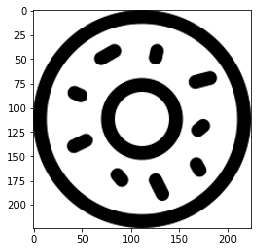

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc
import random
import json
from matplotlib.pyplot import imshow
from PIL import Image, ImageDraw, ImageFont  
from sklearn.manifold import TSNE
%matplotlib inline


def load_image(path):
    img = Image.open(path)
    img = scipy.misc.imresize(np.array(img), (224, 224), interp='bicubic')
#     RGB
    img[:,:,0] = 255.0-img[:,:,3]
    img[:,:,1] = 255.0-img[:,:,3]
    img[:,:,2] = 255.0-img[:,:,3]
    img = img[:,:,:3]
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

img, x = load_image("./doughnut1000/598360.png")
print("shape of x: ", x.shape)
print("data type: ", x.dtype)
plt.imshow(img)

In [7]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)

In [8]:
images_path = './doughnut1000'
image_extensions = ['.jpg', '.png', '.jpeg']   # case-insensitive (upper/lower doesn't matter)
max_num_images = 1000

images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
if max_num_images < len(images):
    images = [images[i] for i in sorted(random.sample(range(len(images)), max_num_images))]

print("keeping %d images to analyze" % len(images))

keeping 1000 images to analyze


In [9]:
import time
tic = time.clock()

features = []
for i, image_path in enumerate(images):
    if i % 100 == 0:
        toc = time.clock()
        elap = toc-tic;
        print("analyzing image %d / %d. Time: %4.4f seconds." % (i, len(images),elap))
        tic = time.clock()
    if not image_path.endswith('DS_Store'):
        img, x = load_image(image_path);
        feat = feat_extractor.predict(x)[0]
        features.append(feat)

print('finished extracting features for %d images' % len(images))

analyzing image 0 / 1000. Time: 0.0002 seconds.


/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


analyzing image 100 / 1000. Time: 216.7481 seconds.
analyzing image 200 / 1000. Time: 215.7895 seconds.
analyzing image 300 / 1000. Time: 215.6089 seconds.
analyzing image 400 / 1000. Time: 217.5334 seconds.
analyzing image 500 / 1000. Time: 216.2070 seconds.
analyzing image 600 / 1000. Time: 214.3293 seconds.
analyzing image 700 / 1000. Time: 217.1756 seconds.
analyzing image 800 / 1000. Time: 216.6256 seconds.
analyzing image 900 / 1000. Time: 214.8787 seconds.
finished extracting features for 1000 images


In [11]:
from sklearn.decomposition import PCA

features = np.array(features)
pca = PCA(n_components=300)
pca.fit(features)
pca_features = pca.transform(features)

In [13]:
# grab a random query image
query_image_idx = int(len(images) * random.random())
print(images[query_image_idx])

./doughnut1000/735604.png


In [14]:
from scipy.spatial import distance

similar_idx = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]

In [15]:
idx_closest = sorted(range(len(similar_idx)), key=lambda k: similar_idx[k])[1:6]

In [16]:
def get_closest_images(query_image_idx, num_results=5):
    distances = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = load_image(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

In [17]:
import pickle

pickle.dump([images, pca_features, pca], open('./doughnut1000/doughnut1000.p', 'wb'))

generating a t-SNE

In [18]:
from sklearn.manifold import TSNE

images, pca_features, pca = pickle.load(open('./doughnut1000/doughnut1000.p', 'rb'))

for img, f in list(zip(images, pca_features))[0:5]:
    print("image: %s, features: %0.2f,%0.2f,%0.2f,%0.2f... "%(img, f[0], f[1], f[2], f[3]))

image: ./doughnut1000/842084.png, features: 14.29,10.67,-1.98,-13.43... 
image: ./doughnut1000/1655199.png, features: 4.53,-15.98,9.16,0.82... 
image: ./doughnut1000/1178522.png, features: -14.93,-6.50,-17.59,-4.53... 
image: ./doughnut1000/1126476.png, features: -5.77,7.13,-10.52,-3.97... 
image: ./doughnut1000/735615.png, features: -42.24,7.86,43.42,-23.34... 


In [19]:
num_images_to_plot = 1000

if len(images) > num_images_to_plot:
    sort_order = sorted(random.sample(range(len(images)), num_images_to_plot))
    images = [images[i] for i in sort_order]
    pca_features = [pca_features[i] for i in sort_order]

In [20]:
X = np.array(pca_features)
tsne = TSNE(n_components=2, learning_rate=150, perplexity=30, angle=0.2, verbose=2).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.015s...
[t-SNE] Computed neighbors for 1000 samples in 0.531s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 9.923786
[t-SNE] Computed conditional probabilities in 0.057s
[t-SNE] Iteration 50: error = 69.7261963, gradient norm = 0.1917030 (50 iterations in 3.194s)
[t-SNE] Iteration 100: error = 68.9500427, gradient norm = 0.2019032 (50 iterations in 3.168s)
[t-SNE] Iteration 150: error = 68.7041779, gradient norm = 0.1813744 (50 iterations in 2.858s)
[t-SNE] Iteration 200: error = 68.7012558, gradient norm = 0.1689273 (50 iterations in 2.884s)
[t-SNE] Iteration 250: error = 68.6538773, gradient norm = 0.1876044 (50 iterations in 2.617s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.653877
[t-SNE] Iteration 300: error = 1.1478713, gradient norm = 0.0011535 (50 iterations in 2.104s)
[t-SNE] Iteration 350: error = 1.0510410, gradient norm = 0.00041

In [21]:
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

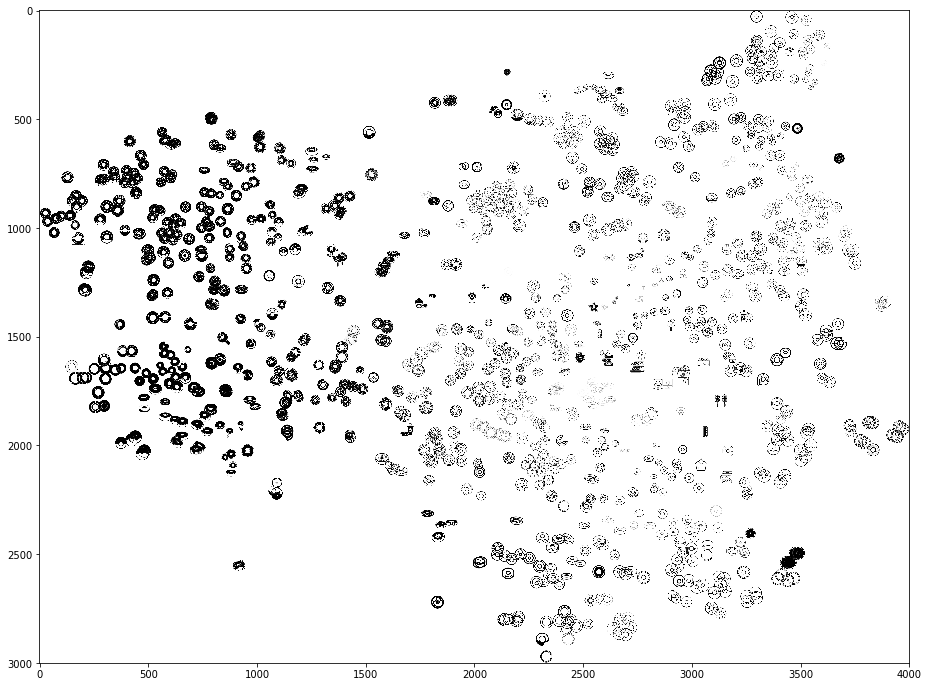

In [23]:
width = 4000
height = 3000
max_dim = 60

full_image = Image.new('RGBA', (width, height))
for img, x, y in zip(images, tx, ty):
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

plt.figure(figsize = (16,12))
imshow(full_image)

In [24]:
full_image.save("./doughnut1000tsne/doughnut1000.png")

In [25]:
tsne_path = "./doughnut1000tsne/doughnut1000.json"

data = [{"path":os.path.abspath(img), "point":[float(x), float(y)]} for img, x, y in zip(images, tx, ty)]
with open(tsne_path, 'w') as outfile:
    json.dump(data, outfile)

print("saved t-SNE result to %s" % tsne_path)

saved t-SNE result to ./doughnut1000tsne/doughnut1000.json


generating a t-SNE grid

In [26]:
import rasterfairy

# nx * ny = 1000, the number of images
nx = 50
ny = 20

# assign to grid
grid_assignment = rasterfairy.transformPointCloud2D(tsne, target=(nx, ny))

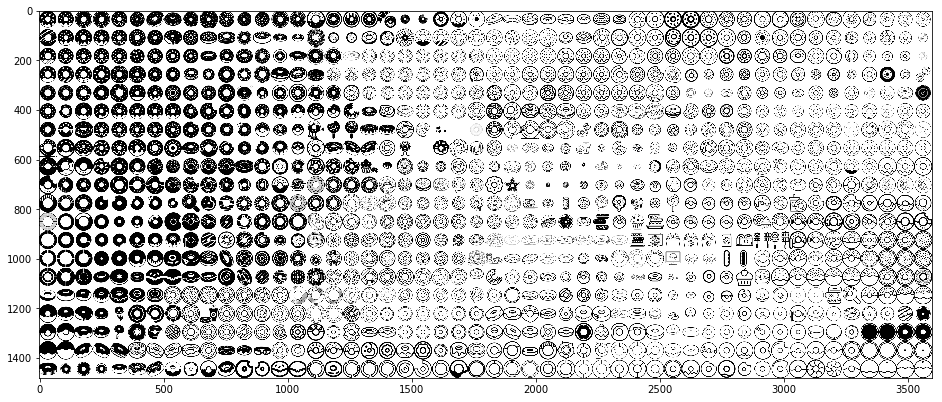

In [27]:
tile_width = 72
tile_height = 74

full_width = tile_width * nx
full_height = tile_height * ny
aspect_ratio = float(tile_width) / tile_height

grid_image = Image.new('RGBA', (full_width, full_height))

for img, grid_pos in zip(images, grid_assignment[0]):
    idx_x, idx_y = grid_pos
    x, y = tile_width * idx_x, tile_height * idx_y
    tile = Image.open(img)
    tile_ar = float(tile.width) / tile.height  # center-crop the tile to match aspect_ratio
    if (tile_ar > aspect_ratio):
        margin = 0.5 * (tile.width - aspect_ratio * tile.height)
        tile = tile.crop((margin, 0, margin + aspect_ratio * tile.height, tile.height))
    else:
        margin = 0.5 * (tile.height - float(tile.width) / aspect_ratio)
        tile = tile.crop((0, margin, tile.width, margin + float(tile.width) / aspect_ratio))
    tile = tile.resize((tile_width, tile_height), Image.ANTIALIAS)
    grid_image.paste(tile, (int(x), int(y)))

plt.figure(figsize = (16,12))
imshow(grid_image)


In [28]:
grid_image.save("./doughnut1000tsne/doughnut1000-grid.png")